# Booking Cancelation Prediction (Logistic Regression & Decision Trees)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# 1.Exploratory Data Analysis

**Read the dataset file**

In [2]:
df=pd.read_csv(r'C:\Users\petur\Python Repository\Capstone 2 - Booking Cancelation Prediction\hotel_bookings.csv', header=0)

**Initial comparisson reveals some distiguishable diffrences between Lead Time and previous cancelations**

In [3]:
df.groupby('is_canceled').mean()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,,,,,,,,,,,,,,,,,,,
0,79.984687,2016.147514,27.080143,15.839529,0.928971,2.464053,1.829737,0.102347,0.010377,0.043344,0.015792,0.202977,0.293364,94.055794,190.519265,1.589868,99.987693,0.0993,0.714060
1,144.848815,2016.171920,27.309696,15.728066,0.925267,2.561912,1.901728,0.106513,0.003821,0.012482,0.208348,0.025122,0.098340,75.179927,183.371117,3.564083,104.964333,0.0000,0.328826


**Check for null values**

In [4]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

**Due to excesive amount of missing records let's get rid of several columns - arrival_date_week_number,agent &company**

In [59]:
df.drop(['arrival_date_week_number','agent', 'company'], axis=1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,Year_Month
0,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,...,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,...,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,...,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,...,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,...,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,30,2,5,2,0.0,...,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017-08-01
119386,City Hotel,0,102,2017,August,31,2,5,3,0.0,...,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017-08-01
119387,City Hotel,0,34,2017,August,31,2,5,2,0.0,...,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017-08-01
119388,City Hotel,0,109,2017,August,31,2,5,2,0.0,...,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017-08-01


## Seasonal Trends

### Arrival Year  to Cancelation Distributions

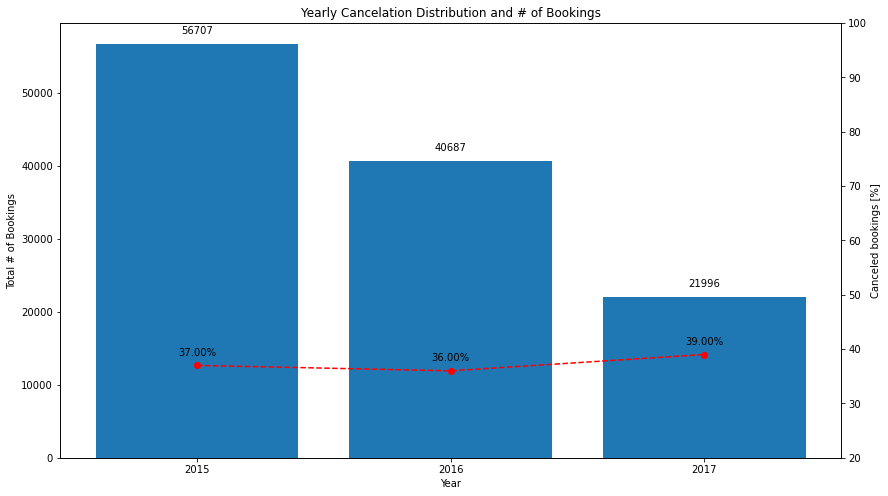

In [6]:
df_plot_year = df.groupby(['arrival_date_year', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='arrival_date_year', values=0)
df_plot_year_pct = round(df_plot_year.div(df_plot_year.sum(1), axis=0),2)*100

df_plot_year_pct_canceled = df_plot_year_pct[1]
bookings = df['arrival_date_year'].value_counts()

fig, ax1 = plt.subplots(figsize = (14,8))
ax1.set_xlabel('Year')
ax1.set_title ('Yearly Cancelation Distribution and # of Bookings')
ax1.bar((2015, 2016 ,2017), bookings)
ax1.set_ylabel('Total # of Bookings')
for x,y in zip([2015, 2016 ,2017], bookings):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')    
ax2 = ax1.twinx()
ax2.plot(df_plot_year_pct_canceled, 'ro--')
ax2.set_xticks([2015, 2016, 2017])
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_ylim((20, 100))

for x,y in zip([2015, 2016 ,2017], df_plot_year_pct_canceled):
    label = "{:.2f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
fig.savefig(r'C:\Users\petur\Desktop\Springboard\Data Analytics Course\16 Capstone 2\graph1.png')

**It looks like cancelations are evenly disperced**

### Arrival Year & Month  to Cancelation Distributions


In [61]:
# New column which concatenates Year and Month
df['Year_Month'] = pd.to_datetime(df.arrival_date_year.astype(str) + '/' + df.arrival_date_month.astype(str))

<ipython-input-64-aa1da17ffaf6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['2015-07','2015-09', '2015-12', '2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-08'], rotation=60)


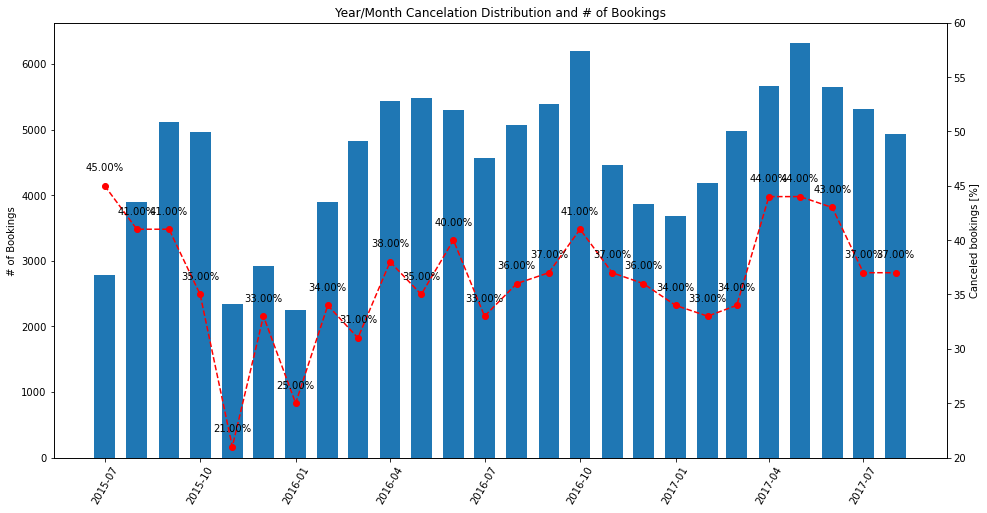

In [64]:
df_plot_year_month = df.groupby(['Year_Month', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='Year_Month',  values=0)
df_plot_year_month_pct = round(df_plot_year_month.div(df_plot_year_month.sum(1), axis=0),2)*100
df_plot_year_month_pct_canceled = df_plot_year_month_pct[1]

bookings = df['Year_Month'].value_counts().sort_values(ascending=False)
bookings = bookings.sort_index()

axis_x=bookings.index

 
fig, ax1 = plt.subplots(figsize=(16,8))

ax1.bar(bookings.index, bookings, width = 20)
ax1.set_title ('Year/Month Cancelation Distribution and # of Bookings')
ax1.set_ylabel('# of Bookings')
ax1.set_xticklabels(['2015-07','2015-09', '2015-12', '2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-08'], rotation=60)

ax2=ax1.twinx()

ax2.plot(df_plot_year_month_pct_canceled, 'ro--')

ax2.set_ylabel('Canceled bookings [%]')
ax2.set_ylim((20, 60))
for x,y in zip(bookings.index, df_plot_year_month_pct_canceled):
    label = "{:.2f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') 
    



**There is a trend of higher cancelation rates during summer months (active season)**

### Arrival Month  to Cancelation Distributions


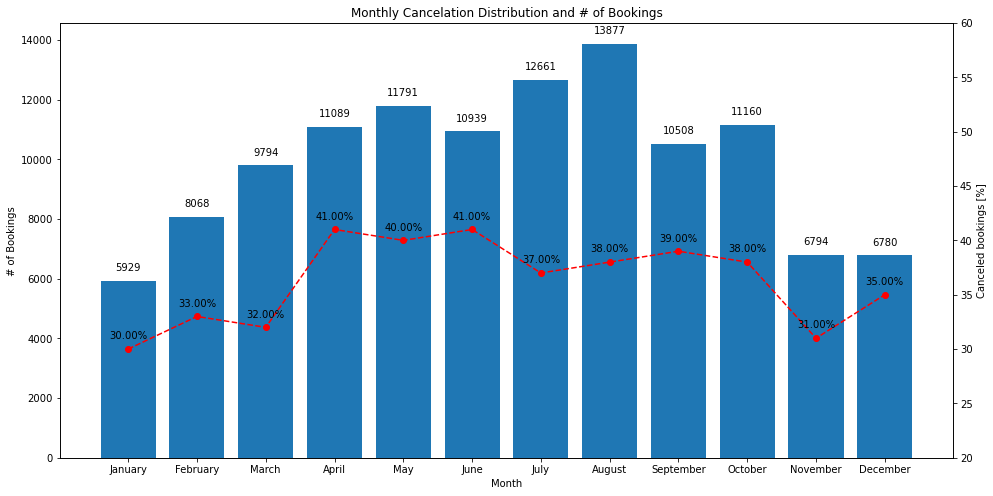

In [9]:
df_plot_month = df.groupby(['arrival_date_month', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='arrival_date_month', values=0)
df_plot_month_pct = round(df_plot_month.div(df_plot_month.sum(1), axis=0),2)*100
df_plot_month_pct_canceled = df_plot_month_pct[1]
df_plot_month_pct_canceled = df_plot_month_pct_canceled.reindex(index=['January','February','March','April','May','June','July','August','September','October','November','December'])

bookings = df['arrival_date_month'].value_counts()
bookings = bookings.reindex(index=['January','February','March','April','May','June','July','August','September','October','November','December'])

axis_x=bookings.index

fig, ax1 = plt.subplots(figsize=(16,8))
ax1.set_xlabel("Month")
ax1.bar(axis_x, bookings)
ax1.set_title('Monthly Cancelation Distribution and # of Bookings')
ax1.set_ylabel('# of Bookings')
for x,y in zip(axis_x, bookings):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
ax2=ax1.twinx()

ax2.plot(axis_x, df_plot_month_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_ylim((20, 60))
for x,y in zip(axis_x, df_plot_month_pct_canceled):
    label = "{:.2f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 

**A confirmation of the above stated trend could be observed here - spring/summer months lead by percentage of cancelations**

### Arrival Day of Month to Cancelation Distributions

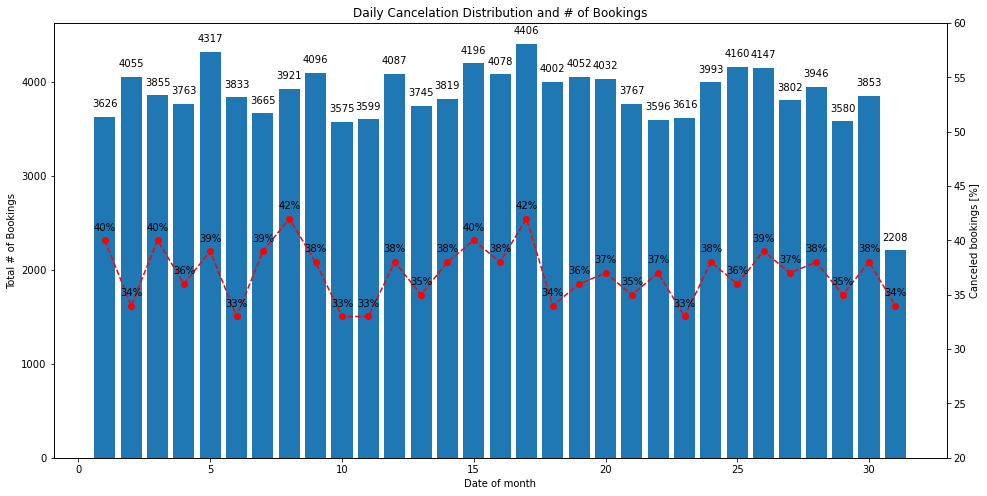

In [10]:
df_plot_day = df.groupby(['arrival_date_day_of_month', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='arrival_date_day_of_month', values=0)
df_plot_day_pct = round(df_plot_day.div(df_plot_day.sum(1), axis=0),2)*100
df_plot_day_pct_canceled = df_plot_day_pct[1]

bookings = df['arrival_date_day_of_month'].value_counts()
bookings = bookings.sort_index()

x_axis = bookings.index


fig, ax1 = plt.subplots(figsize = (16,8))
ax1.set_xlabel('Date of month')
ax1.bar(x_axis, bookings)
ax1.set_title ('Daily Cancelation Distribution and # of Bookings')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, bookings):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')    
ax2 = ax1.twinx()

ax2.plot(df_plot_day_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Day #')
ax2.set_ylim((20, 60))

for x,y in zip(x_axis, df_plot_day_pct_canceled):
    label = "{:.0f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 

**Two peak canceltion dates are noticable - 8th and 17th, still not clear whether it is a reliable predictor**

## Categorical variables

### Hotel Type to Cancelation Distribution

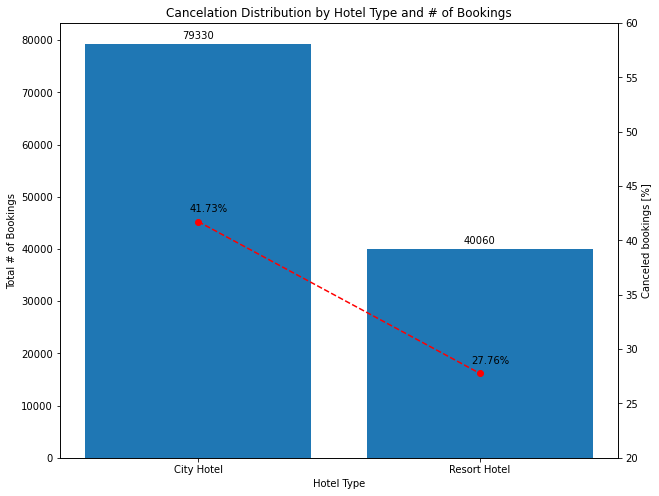

In [11]:
df_plot_hotel = df.groupby(['hotel', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='hotel', values=0)
df_plot_hotel_pct = round(df_plot_hotel.div(df_plot_hotel.sum(1), axis=0)*100.00,2)
df_plot_hotel_pct_canceled = df_plot_hotel_pct[1]


bookings = df['hotel'].value_counts()
bookings = bookings.sort_index()

x_axis = bookings.index

fig, ax1 = plt.subplots(figsize = (10,8))
ax1.set_xlabel('Hotel Type')
ax1.bar(x_axis, bookings)
ax1.set_title ('Cancelation Distribution by Hotel Type and # of Bookings')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, bookings):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    
ax2 = ax1.twinx()

ax2.plot(df_plot_hotel_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_ylim((20, 60))
for x,y in zip(x_axis, df_plot_hotel_pct_canceled):
    label = "{:.2f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center') 

**Given the uneven bookings distribution between the two categories it is not clear whether or not there is a significant trend**

### Meal Type booked

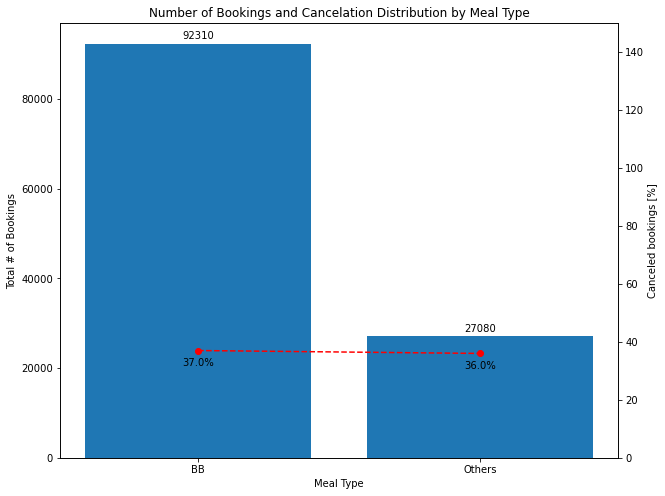

In [12]:
#Create Series
plot_meal = df.groupby(['meal', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='meal', values=0)
plot_meal = plot_meal.fillna(0)


# Create Dictionary & Data Frame
plot_meal_dict = {'not_canceled':plot_meal[0], 'canceled':plot_meal[1]}
df_plot_meal = pd.DataFrame(plot_meal_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_meal['total_bookings'] = df_plot_meal['not_canceled']+df_plot_meal['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_meal_sorted = df_plot_meal.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_meal_top = df_plot_meal.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_meal_top.set_index("meal", inplace=True)

#Add a row with all the rest 
df_plot_meal_top.loc['Others',:] = df_plot_meal_sorted.iloc[1:, 1:4].sum(axis=0)

#Calc the percentage of cancelations
df_plot_meal_top_pct = round(df_plot_meal_top.div(df_plot_meal_top['total_bookings'], axis=0), 2)*100
df_plot_meal_top_pct = df_plot_meal_top_pct.drop(['total_bookings'], axis=1)
df_plot_meal_top_pct_canceled = df_plot_meal_top_pct['canceled']



x_axis = df_plot_meal_top_pct.index

fig, ax1 = plt.subplots(figsize = (10,8))
ax1.set_xlabel("Meal Type")
ax1.bar(x_axis,df_plot_meal_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Meal Type')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_meal_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()
ax2.plot(df_plot_meal_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Country')
ax2.set_ylim((0, 150))
for x,y in zip(x_axis, df_plot_meal_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')




**Meal type could not be used as predictor**

### Country

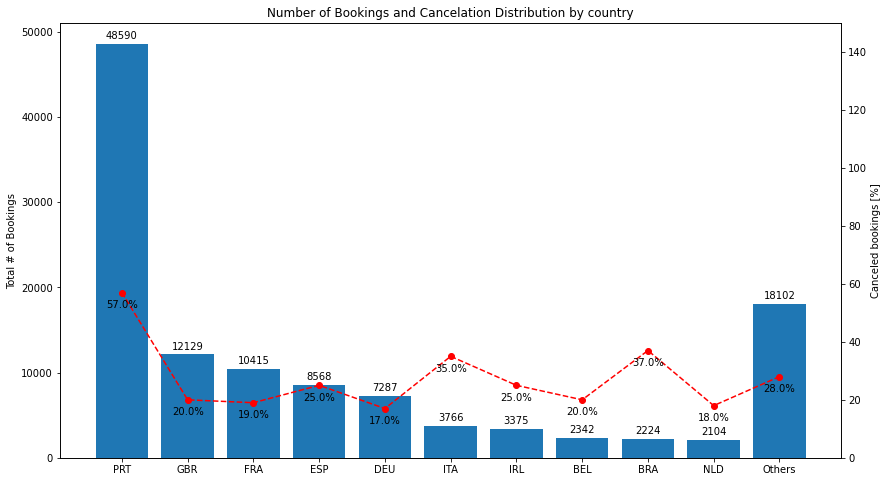

In [13]:
#Create Series
plot_country = df.groupby(['country', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='country', values=0)
plot_country = plot_country.fillna(0)

# Create Dictionary & Data Frame
country_dict = {'not_canceled':plot_country[0], 'canceled':plot_country[1]}
df_plot_country = pd.DataFrame(country_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_country['total_bookings'] = df_plot_country['not_canceled']+df_plot_country['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_country_sorted = df_plot_country.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_country_sorted_top10 = df_plot_country.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:10]
df_plot_country_sorted_top10.set_index("country", inplace=True)

#Add a row with all the rest 
df_plot_country_sorted_top10.loc['Others',:] = df_plot_country_sorted.iloc[10:, 1:4].sum(axis=0)
df_plot_country_sorted_top10

#Calc the percentage of cancelations
df_plot_country_pct = round(df_plot_country_sorted_top10.div(df_plot_country_sorted_top10['total_bookings'], axis=0), 2)*100
df_plot_country_pct = df_plot_country_pct.drop(['total_bookings'], axis=1)
df_plot_country_pct_canceled = df_plot_country_pct['canceled']
df_plot_country_pct_canceled


#Axis X
x_axis = df_plot_country_sorted_top10.index


fig, ax1 = plt.subplots(figsize = (14,8))

ax1.bar(x_axis, df_plot_country_sorted_top10['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by country')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_country_sorted_top10['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_country_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Country')
ax2.set_ylim((0, 150))
for x,y in zip(x_axis, df_plot_country_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center')

Looking at top 10 countries by number of reservations and rest

**It looks like Portugal has significantly higher number of cancelations**

### Market Segment Cancelation Disrtibution


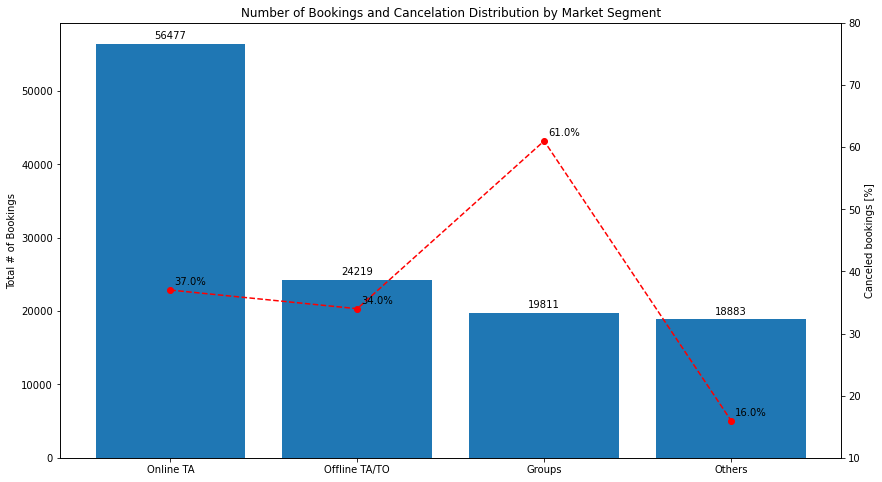

In [14]:
#Create Series
plot_market_segment = df.groupby(['market_segment', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='market_segment', values=0)
plot_market_segment = plot_market_segment.fillna(0)


# Create Dictionary & Data Frame
market_segment_dict = {'not_canceled':plot_market_segment[0], 'canceled':plot_market_segment[1]}
df_plot_market_segment = pd.DataFrame(market_segment_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_market_segment['total_bookings'] = df_plot_market_segment['not_canceled']+df_plot_market_segment['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_market_segment_sorted = df_plot_market_segment.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_market_segment_sorted_top3 = df_plot_market_segment.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:3]
df_plot_market_segment_sorted_top3.set_index("market_segment", inplace=True)

#Add a row with all the rest 
df_plot_market_segment_sorted_top3.loc['Others',:] = df_plot_market_segment_sorted.iloc[3:, 1:4].sum(axis=0)

#Calc the percentage of cancelations
df_plot_market_segment_pct = round(df_plot_market_segment_sorted_top3.div(df_plot_market_segment_sorted_top3['total_bookings'], axis=0), 2)*100
df_plot_market_segment_pct = df_plot_market_segment_pct.drop(['total_bookings'], axis=1)
df_plot_market_segment_pct_canceled = df_plot_market_segment_pct['canceled']


#Axis X
x_axis = df_plot_market_segment_sorted_top3.index


fig, ax1 = plt.subplots(figsize = (14,8))

ax1.bar(x_axis, df_plot_market_segment_sorted_top3['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Market Segment')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_market_segment_sorted_top3['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_market_segment_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Market Segment')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_market_segment_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,5), # distance from text to points (x,y)
                 ha='center')

**It looks that Groups tend to cancel their bookings more often then the rest**

### Distribution Channel

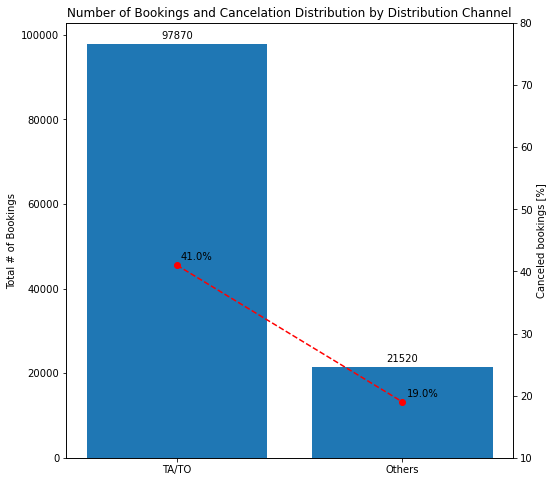

In [15]:
#Create Series
plot_distribution_channel = df.groupby(['distribution_channel', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='distribution_channel', values=0)
plot_distribution_channel = plot_distribution_channel.fillna(0)


# Create Dictionary & Data Frame
distribution_channel_dict = {'not_canceled':plot_distribution_channel[0], 'canceled':plot_distribution_channel[1]}
df_plot_distribution_channel = pd.DataFrame(distribution_channel_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_distribution_channel['total_bookings'] = df_plot_distribution_channel['not_canceled']+df_plot_distribution_channel['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_distribution_channel_sorted = df_plot_distribution_channel.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_distribution_channel_top = df_plot_distribution_channel.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_distribution_channel_top.set_index("distribution_channel", inplace=True)

#Add a row with all the rest 
df_plot_distribution_channel_top.loc['Others',:] = df_plot_distribution_channel_sorted.iloc[1:, 1:4].sum(axis=0)

#Calc the percentage of cancelations
df_plot_distribution_channel_pct = round(df_plot_distribution_channel_top.div(df_plot_distribution_channel_top['total_bookings'], axis=0), 2)*100
df_plot_distribution_channel_pct = df_plot_distribution_channel_pct.drop(['total_bookings'], axis=1)
df_plot_distribution_channel_pct_canceled = df_plot_distribution_channel_pct['canceled']

#Axis X
x_axis = df_plot_distribution_channel_top.index

fig, ax1 = plt.subplots(figsize = (8,8))

ax1.bar(x_axis, df_plot_distribution_channel_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Distribution Channel')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_distribution_channel_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_distribution_channel_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Distribution Channel')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_distribution_channel_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,5), # distance from text to points (x,y)
                 ha='center')

**Distribution channel TA/TO is prone to higher number of cancelations**

### Room type cancelation distribution


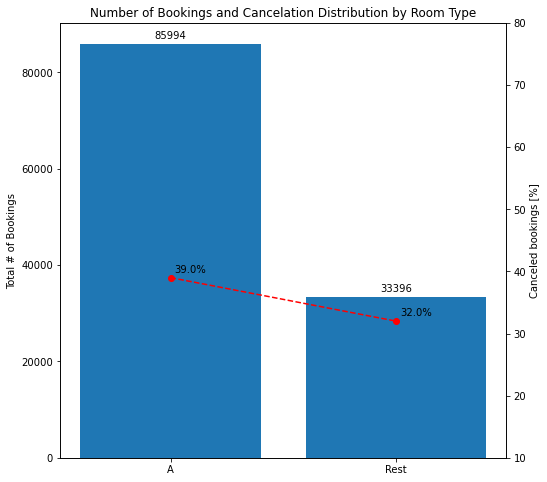

In [16]:
#Create Series
plot_reserved_room_type = df.groupby(['reserved_room_type', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='reserved_room_type', values=0)
plot_reserved_room_type = plot_reserved_room_type.fillna(0)


# Create Dictionary & Data Frame
plot_reserved_room_type_dict = {'not_canceled':plot_reserved_room_type[0], 'canceled':plot_reserved_room_type[1]}
df_plot_reserved_room_typel = pd.DataFrame(plot_reserved_room_type_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_reserved_room_typel['total_bookings'] = df_plot_reserved_room_typel['not_canceled']+df_plot_reserved_room_typel['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_reserved_room_typel_sorted = df_plot_reserved_room_typel.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_reserved_room_typel_top = df_plot_reserved_room_typel.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_reserved_room_typel_top.set_index("reserved_room_type", inplace=True)

#Add a row with all the rest 
df_plot_reserved_room_typel_top.loc['Rest',:] = df_plot_reserved_room_typel_sorted.iloc[1:, 1:4].sum(axis=0)


df_plot_reserved_room_type_pct = round(df_plot_reserved_room_typel_top.div(df_plot_reserved_room_typel_top['total_bookings'], axis=0), 2)*100
df_plot_reserved_room_type_pct = df_plot_reserved_room_type_pct.drop(['total_bookings'], axis=1)
df_plot_reserved_room_type_pct_canceled = df_plot_reserved_room_type_pct['canceled']

#Axis X
x_axis = df_plot_reserved_room_typel_top.index

fig, ax1 = plt.subplots(figsize = (8,8))

ax1.bar(x_axis, df_plot_reserved_room_typel_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Room Type')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_reserved_room_typel_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_reserved_room_type_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Room Type')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_reserved_room_type_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,5), # distance from text to points (x,y)
                 ha='center')

**There is no significant difference between the room types cancelation**

### Room Type Assigned

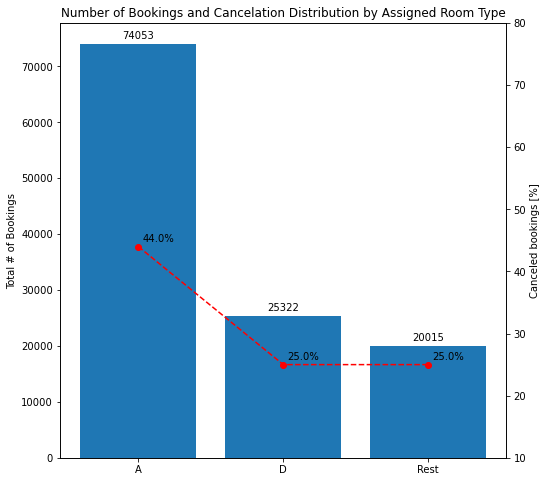

In [17]:
#Create Series
plot_assigned_room_type = df.groupby(['assigned_room_type', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='assigned_room_type', values=0)
plot_assigned_room_type = plot_assigned_room_type.fillna(0)


# Create Dictionary & Data Frame
plot_assigned_room_type_dict = {'not_canceled':plot_assigned_room_type[0], 'canceled':plot_assigned_room_type[1]}
df_plot_assigned_room_type = pd.DataFrame(plot_assigned_room_type_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_assigned_room_type['total_bookings'] = df_plot_assigned_room_type['not_canceled']+df_plot_assigned_room_type['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_assigned_room_type_sorted = df_plot_assigned_room_type.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_assigned_room_type_top = df_plot_assigned_room_type.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:2]
df_plot_assigned_room_type_top.set_index("assigned_room_type", inplace=True)

#Add a row with all the rest 
df_plot_assigned_room_type_top.loc['Rest',:] = df_plot_assigned_room_type_sorted.iloc[2:, 1:4].sum(axis=0)

df_plot_assigned_room_type_pct = round(df_plot_assigned_room_type_top.div(df_plot_assigned_room_type_top['total_bookings'], axis=0), 2)*100
df_plot_assigned_room_type_pct = df_plot_assigned_room_type_pct.drop(['total_bookings'], axis=1)
df_plot_assigned_room_type_pct_canceled = df_plot_assigned_room_type_pct['canceled']

#Axis X
x_axis = df_plot_assigned_room_type_top.index

fig, ax1 = plt.subplots(figsize = (8,8))

ax1.bar(x_axis, df_plot_assigned_room_type_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Assigned Room Type')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_assigned_room_type_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_assigned_room_type_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Assigned Room Type')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_assigned_room_type_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,5), # distance from text to points (x,y)
                 ha='center')

**Assigned room type A has more cancelations but significantly more bookings as well**

### Deposit Type

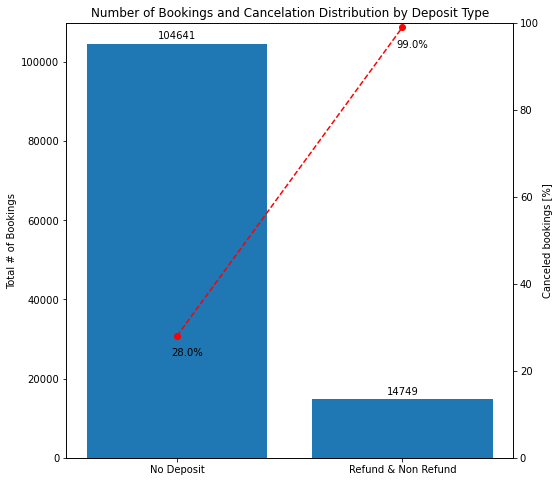

In [18]:
#Create Series
plot_deposit_type = df.groupby(['deposit_type', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='deposit_type', values=0)
plot_deposit_type = plot_deposit_type.fillna(0)


# Create Dictionary & Data Frame
plot_deposit_type_dict = {'not_canceled':plot_deposit_type[0], 'canceled':plot_deposit_type[1]}
df_plot_deposit_type = pd.DataFrame(plot_deposit_type_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_deposit_type['total_bookings'] = df_plot_deposit_type['not_canceled']+df_plot_deposit_type['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_deposit_type_sorted = df_plot_deposit_type.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_deposit_type_top = df_plot_deposit_type.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_deposit_type_top.set_index("deposit_type", inplace=True)

#Add a row with all the rest 
df_plot_deposit_type_top.loc['Refund & Non Refund',:] = df_plot_deposit_type_sorted.iloc[1:, 1:4].sum(axis=0)


df_plot_deposit_type_pct = round(df_plot_deposit_type_top.div(df_plot_deposit_type_top['total_bookings'], axis=0), 2)*100
df_plot_deposit_type_pct = df_plot_deposit_type_pct.drop(['total_bookings'], axis=1)
df_plot_deposit_type_pct_canceled = df_plot_deposit_type_pct['canceled']

#Axis X
x_axis = df_plot_deposit_type_top.index

fig, ax1 = plt.subplots(figsize = (8,8))

ax1.bar(x_axis, df_plot_deposit_type_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Deposit Type')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_deposit_type_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_deposit_type_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Room Type')
ax2.set_ylim((0, 100))
for x,y in zip(x_axis, df_plot_deposit_type_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Deposit type could not be reliable predictior since it is evaluated after cancelation**

### Customer Type

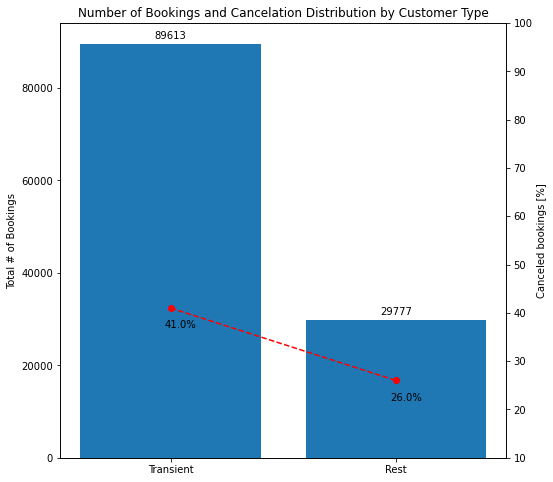

In [19]:
#Create Series
plot_customer_type = df.groupby(['customer_type', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='customer_type', values=0)
plot_customer_type = plot_customer_type.fillna(0)


# Create Dictionary & Data Frame
plot_customer_type_dict = {'not_canceled':plot_customer_type[0], 'canceled':plot_customer_type[1]}
df_plot_customer_type = pd.DataFrame(plot_customer_type_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_customer_type['total_bookings'] = df_plot_customer_type['not_canceled']+df_plot_customer_type['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_customer_type_sorted = df_plot_customer_type.sort_values(by=['total_bookings'], ascending=False)


#Take out top 10 countries by # of 'total_bookings'
df_plot_customer_type_top = df_plot_customer_type.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_customer_type_top.set_index("customer_type", inplace=True)

#Add a row with all the rest 
df_plot_customer_type_top.loc['Rest',:] = df_plot_customer_type_sorted.iloc[1:, 1:4].sum(axis=0)


df_plot_customer_type_pct = round(df_plot_customer_type_top.div(df_plot_customer_type_top['total_bookings'], axis=0), 2)*100
df_plot_customer_type_pct = df_plot_customer_type_pct.drop(['total_bookings'], axis=1)
df_plot_customer_type_pct_canceled = df_plot_customer_type_pct['canceled']

#Axis X
x_axis = df_plot_customer_type_top.index


fig, ax1 = plt.subplots(figsize = (8,8))

ax1.bar(x_axis, df_plot_customer_type_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Customer Type')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_customer_type_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(df_plot_customer_type_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Customer Type')
ax2.set_ylim((10, 100))
for x,y in zip(x_axis, df_plot_customer_type_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Againg the significant difference in bookings number obstructs possible conclusion**

### Week nights to Cancelation Distribution

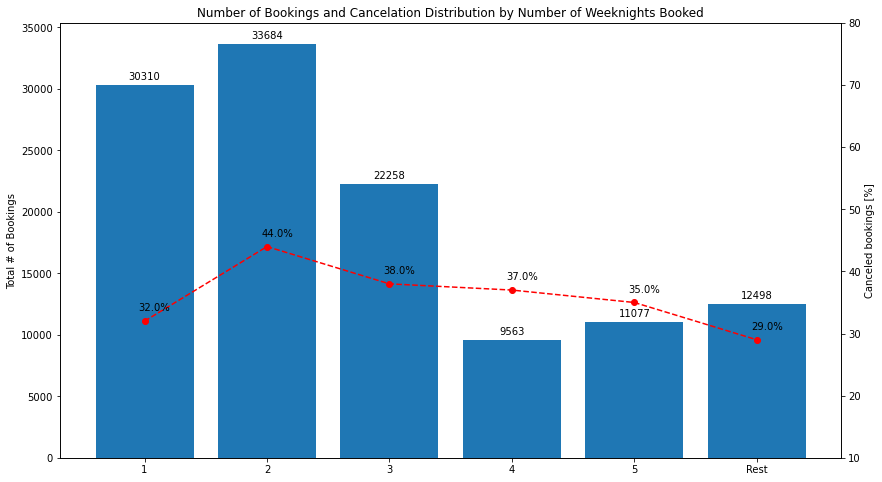

In [20]:
#Create Series
plot_weeknights = df.groupby(['stays_in_week_nights', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='stays_in_week_nights', values=0)
plot_weeknights = plot_weeknights.fillna(0)


# Create Dictionary & Data Frame
plot_weeknights_dict = {'not_canceled':plot_weeknights[0], 'canceled':plot_weeknights[1]}
df_plot_weeknights = pd.DataFrame(plot_weeknights_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_weeknights['total_bookings'] = df_plot_weeknights['not_canceled']+df_plot_weeknights['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_weeknights_sorted = df_plot_weeknights.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_weeknights_top = df_plot_weeknights.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:5]
df_plot_weeknights_top.set_index("stays_in_week_nights", inplace=True)


#Add a row with all the rest 
df_plot_weeknights_top.loc['Rest',:] = df_plot_weeknights_sorted.iloc[5:, 1:4].sum(axis=0)

df_plot_weeknights_top.index = df_plot_weeknights_top.index.astype(str)
df_plot_weeknights_top= df_plot_weeknights_top.sort_index()
df_plot_weeknights_top

df_plot_weeknights_top_pct = round(df_plot_weeknights_top.div(df_plot_weeknights_top['total_bookings'], axis=0), 2)*100
df_plot_weeknights_top_pct = df_plot_weeknights_top_pct.drop(['total_bookings'], axis=1)
df_plot_weeknights_top_pct_canceled = df_plot_weeknights_top_pct['canceled']

#Axis X
x_axis = df_plot_weeknights_top.index

fig, ax1 = plt.subplots(figsize = (14,8))

ax1.bar(x_axis, df_plot_weeknights_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Weeknights Booked')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_weeknights_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_weeknights_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Customer Type')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_weeknights_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center')



**Weeknights booked looks promising predictor**

### WeekEND nights to Cancelation Distribution

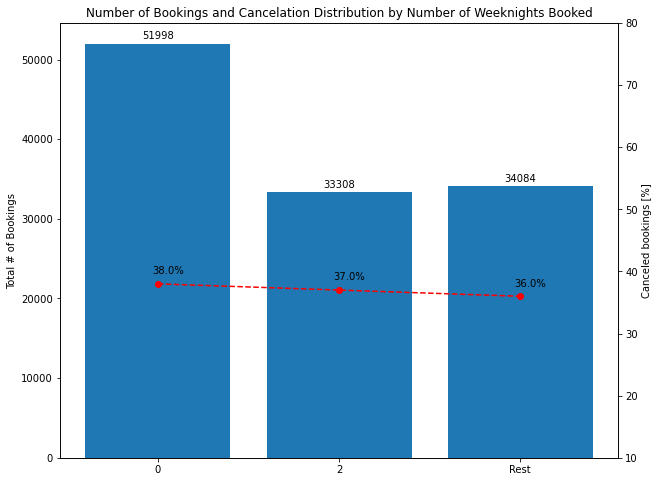

In [21]:
#Create Series
plot_weekENDnights = df.groupby(['stays_in_weekend_nights', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='stays_in_weekend_nights', values=0)
plot_weekENDnights = plot_weekENDnights.fillna(0)


# Create Dictionary & Data Frame
stays_in_weekend_nights_dict = {'not_canceled':plot_weekENDnights[0], 'canceled':plot_weekENDnights[1]}
df_plot_weekENDnights = pd.DataFrame(stays_in_weekend_nights_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_weekENDnights['total_bookings'] = df_plot_weekENDnights['not_canceled']+df_plot_weekENDnights['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_weekENDnights_sorted = df_plot_weekENDnights.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_weekENDnights_top = df_plot_weekENDnights.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:2]
df_plot_weekENDnights_top.set_index("stays_in_weekend_nights", inplace=True)

#Add a row with all the rest 
df_plot_weekENDnights_top.loc['Rest',:] = df_plot_weekENDnights_sorted.iloc[2:, 1:4].sum(axis=0)


df_plot_weekENDnights_top_pct = round(df_plot_weekENDnights_top.div(df_plot_weekENDnights_top['total_bookings'], axis=0), 2)*100
df_plot_weekENDnights_top_pct = df_plot_weekENDnights_top_pct.drop(['total_bookings'], axis=1)
df_plot_weekENDnights_top_canceled = df_plot_weekENDnights_top_pct['canceled']

#Axis X
x_axis = ['0', '2', 'Rest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_weekENDnights_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Weeknights Booked')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_weekENDnights_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_weekENDnights_top_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Customer Type')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_weekENDnights_top_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center')

**No clear pattern could be seen**

### Number of adults in each reservation

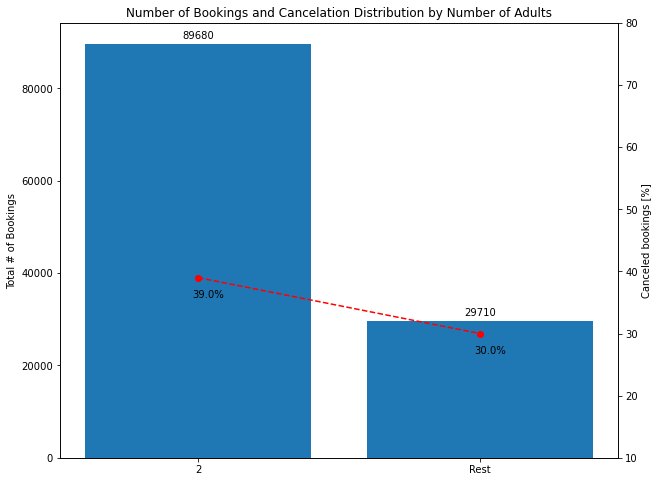

In [22]:
#Create Series
plot_adults = df.groupby(['adults', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='adults', values=0)
plot_adults = plot_adults.fillna(0)


# Create Dictionary & Data Frame
plot_adults_dict = {'not_canceled':plot_adults[0], 'canceled':plot_adults[1]}
df_plot_adults = pd.DataFrame(plot_adults_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_adults['total_bookings'] = df_plot_adults['not_canceled']+df_plot_adults['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_adults_sorted = df_plot_adults.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_adults_top = df_plot_adults.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_adults_top.set_index("adults", inplace=True)

#Add a row with all the rest 
df_plot_adults_top.loc['Rest',:] = df_plot_adults_sorted.iloc[1:, 1:4].sum(axis=0)
 

df_plot_adults_top_pct = round(df_plot_adults_top.div(df_plot_adults_top['total_bookings'], axis=0), 2)*100
df_plot_adults_top_pct = df_plot_adults_top_pct.drop(['total_bookings'], axis=1)
df_plot_adults_top_pct_canceled = df_plot_adults_top_pct['canceled']
 
#Axis X
x_axis = ['2', 'Rest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_adults_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Adults')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_adults_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_adults_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Adults')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_adults_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Number of adults could not be used as predictor**

### Children

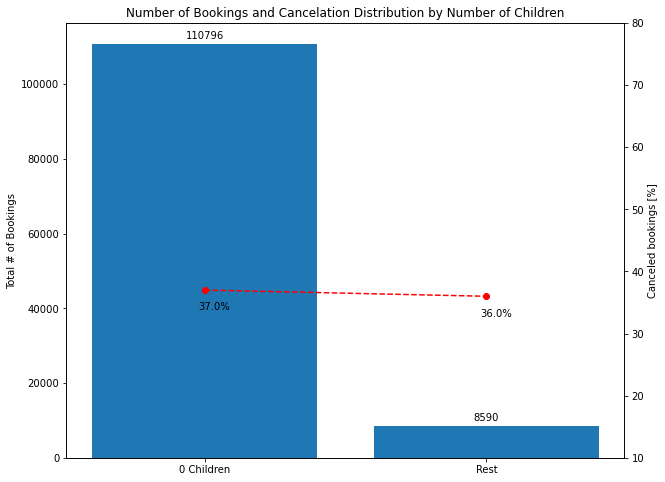

In [23]:
#Create Series
plot_children = df.groupby(['children', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='children', values=0)
plot_children = plot_children.fillna(0)


# Create Dictionary & Data Frame
plot_children_dict = {'not_canceled':plot_children[0], 'canceled':plot_children[1]}
df_plot_children = pd.DataFrame(plot_children_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_children['total_bookings'] = df_plot_children['not_canceled']+df_plot_children['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_children_sorted = df_plot_children.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_children_top = df_plot_children.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_children_top.set_index("children", inplace=True)

#Add a row with all the rest 
df_plot_children_top.loc['Rest',:] = df_plot_children_sorted.iloc[1:, 1:4].sum(axis=0)


df_plot_children_top_pct = round(df_plot_children_top.div(df_plot_children_top['total_bookings'], axis=0), 2)*100
df_plot_children_top_pct_canceled = df_plot_children_top_pct['canceled']

#Axis X
x_axis = ['0 Children', 'Rest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_children_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Children')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_children_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_children_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Children')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_children_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**No clear pattern is observed**

### Babies
It seems that families with babies make less cancelations

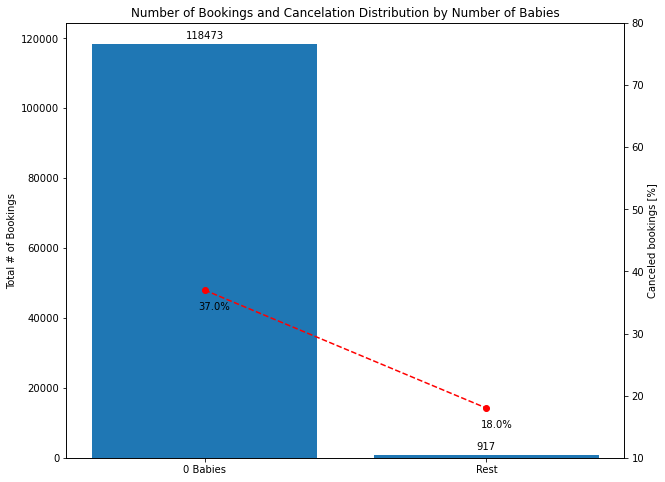

In [24]:
#Create Series
plot_babies = df.groupby(['babies', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='babies', values=0)
plot_babies = plot_babies.fillna(0)


# Create Dictionary & Data Frame
plot_babies_dict = {'not_canceled':plot_babies[0], 'canceled':plot_babies[1]}
df_plot_babies = pd.DataFrame(plot_babies_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_babies['total_bookings'] = df_plot_babies['not_canceled'] + df_plot_babies['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_babies_sorted = df_plot_babies.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_babies_top = df_plot_babies.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_babies_top.set_index('babies', inplace=True)

#Add a row with all the rest 
df_plot_babies_top.loc['Rest',:] = df_plot_babies_sorted.iloc[1:, 1:4].sum(axis=0)


df_plot_babies_top_pct = round(df_plot_babies_top.div(df_plot_babies_top['total_bookings'], axis=0), 2)*100
df_plot_babies_top_pct_canceled = df_plot_babies_top_pct['canceled']

#Axis X
x_axis = ['0 Babies', 'Rest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_babies_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Babies')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_babies_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_babies_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Babies')
ax2.set_ylim((10, 80))
for x,y in zip(x_axis, df_plot_babies_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Even though temped to draw conclusions based on the graph it will not be corret to do so due to too few bookings with babies**

### Repeat

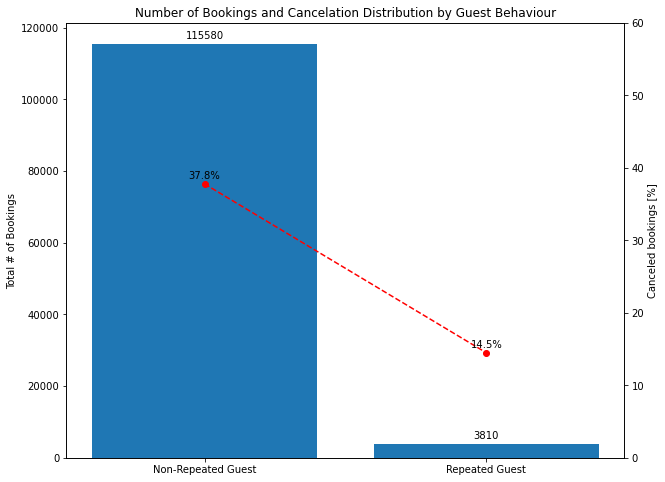

In [65]:
plot_rep_guest = df.groupby(['is_repeated_guest', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='is_repeated_guest', values=0)
plot_rep_guest_pct = round(plot_rep_guest.div(plot_rep_guest.sum(1), axis=0)*100,2)
plot_rep_guest_pct_canceled = plot_rep_guest_pct[1]

bookings = df['is_repeated_guest'].value_counts()
bookings = bookings.sort_index()

x_axis = ['Non-Repeated Guest','Repeated Guest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, bookings)
ax1.set_title ('Number of Bookings and Cancelation Distribution by Guest Behaviour')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, bookings):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis, plot_rep_guest_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Meal Type')
ax2.set_ylim((0, 60))
for x,y in zip(x_axis, plot_rep_guest_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')

**As expected repeated guests are canceling less often but again the amount of bookings is not evenly distributed**

### Number of Previous Cancelations as factor for future Cancelations

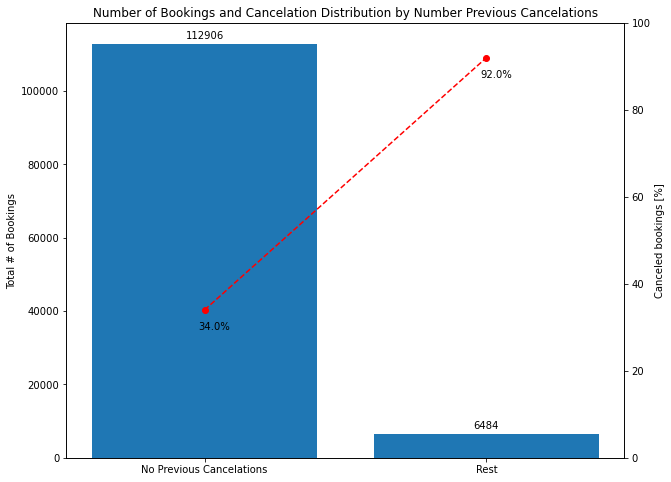

In [26]:
#Create Series
plot_prev_canc = df.groupby(['previous_cancellations', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='previous_cancellations', values=0)
plot_prev_canc = plot_prev_canc.fillna(0)


# Create Dictionary & Data Frame
plot_prev_canc_dict = {'not_canceled':plot_prev_canc[0], 'canceled':plot_prev_canc[1]}
df_plot_prev_canc = pd.DataFrame(plot_prev_canc_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_prev_canc['total_bookings'] = df_plot_prev_canc['not_canceled'] + df_plot_prev_canc['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_prev_canc_sorted = df_plot_prev_canc.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_prev_canc_top = df_plot_prev_canc.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_prev_canc_top.set_index('previous_cancellations', inplace=True)

#Add a row with all the rest 
df_plot_prev_canc_top.loc['Rest',:] = df_plot_prev_canc_sorted.iloc[1:, 1:4].sum(axis=0)
 

df_plot_prev_canc_top_pct = round(df_plot_prev_canc_top.div(df_plot_prev_canc_top['total_bookings'], axis=0), 2)*100
df_plot_prev_canc_top_canceled = df_plot_prev_canc_top_pct['canceled']
 

#Axis X
x_axis = ['No Previous Cancelations', 'Rest']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_prev_canc_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number Previous Cancelations')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_prev_canc_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_prev_canc_top_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Babies')
ax2.set_ylim((0, 100))
for x,y in zip(x_axis, df_plot_prev_canc_top_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Data shows that clients with previous cancelations tend to cancel their bookings more often**

### Not canceled previous reservations

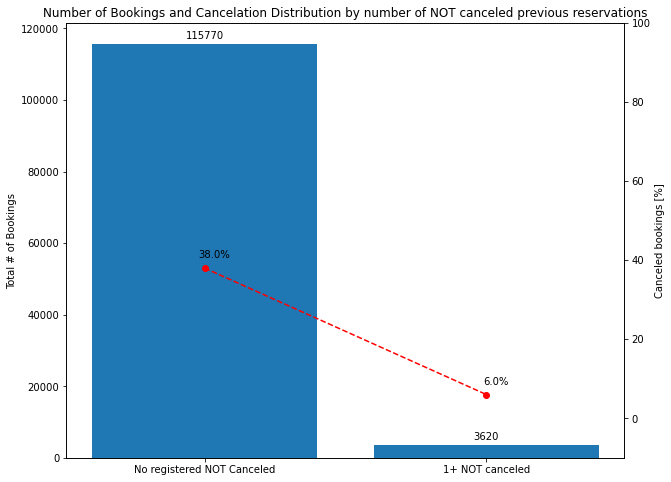

In [67]:
#Create Series
plot_prevNOTcancel = df.groupby(['previous_bookings_not_canceled', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='previous_bookings_not_canceled', values=0)
plot_prevNOTcancel = plot_prevNOTcancel.fillna(0)


# Create Dictionary & Data Frame
plot_prevNOTcancel_dict = {'not_canceled':plot_prevNOTcancel[0], 'canceled':plot_prevNOTcancel[1]}
df_plot_prevNOTcancel = pd.DataFrame(plot_prevNOTcancel_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_prevNOTcancel['total_bookings'] = df_plot_prevNOTcancel['not_canceled'] + df_plot_prevNOTcancel['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_prevNOTcancel_sorted = df_plot_prevNOTcancel.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_prevNOTcancel_top = df_plot_prevNOTcancel.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_prevNOTcancel.set_index('previous_bookings_not_canceled', inplace=True)

#Add a row with all the rest 
df_plot_prevNOTcancel_top.loc['1 + cancelations',:] = df_plot_prevNOTcancel_sorted.iloc[1:, 1:4].sum(axis=0)
df_plot_prevNOTcancel_top = df_plot_prevNOTcancel_top.drop(['previous_bookings_not_canceled'], axis=1)

#Calc percentage cancelations
df_plot_prevNOTcancel_top_pct = round(df_plot_prevNOTcancel_top.div(df_plot_prevNOTcancel_top['total_bookings'], axis=0), 2)*100
df_plot_prevNOTcancel_top_pct_canceled = df_plot_prevNOTcancel_top_pct['canceled']
df_plot_prevNOTcancel_top_pct_canceled

x_axis = ['No registered NOT Canceled', '1+ NOT canceled']

fig, ax1 = plt.subplots(figsize = (10,8))
ax1.bar(x_axis, df_plot_prevNOTcancel_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by number of NOT canceled previous reservations')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_prevNOTcancel_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') 

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_prevNOTcancel_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Lead Time')
ax2.set_ylim((-10, 100))
for x,y in zip(x_axis, df_plot_prevNOTcancel_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center')

**Significant number of reservations are coming from new guest (no history) thus it is hard to draw conclusions**

### Booking changes made

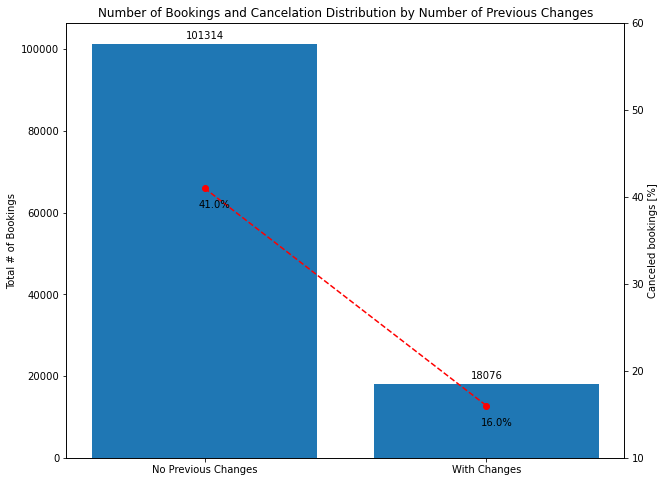

In [28]:
#Create Series
plot_book_change = df.groupby(['booking_changes', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='booking_changes', values=0)
plot_book_change = plot_book_change.fillna(0)


# Create Dictionary & Data Frame
plot_book_change_dict = {'not_canceled':plot_book_change[0], 'canceled':plot_book_change[1]}
df_plot_book_change = pd.DataFrame(plot_book_change_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_book_change['total_bookings'] = df_plot_book_change['not_canceled'] + df_plot_book_change['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_book_change_sorted = df_plot_book_change.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_book_change_top = df_plot_book_change.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_book_change_top.set_index('booking_changes', inplace=True)

#Add a row with all the rest 
df_plot_book_change_top.loc['With Changes',:] = df_plot_book_change_sorted.iloc[1:, 1:4].sum(axis=0)
df_plot_book_change_top_pct = round(df_plot_book_change_top.div(df_plot_book_change_top['total_bookings'], axis=0), 2)*100
df_plot_book_change_top_pct_canceled = df_plot_book_change_top_pct['canceled']


#Axis X
x_axis = ['No Previous Changes', 'With Changes']

fig, ax1 = plt.subplots(figsize = (10,8))

ax1.bar(x_axis, df_plot_book_change_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Number of Previous Changes')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_book_change_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_book_change_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Booking Changes')
ax2.set_ylim((10, 60))
for x,y in zip(x_axis, df_plot_book_change_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**This variable could work only with repeated clients**

## Continuous variables to booking cancelations

### Lead Time (how many days in advance the reservation is made) to Cancelations

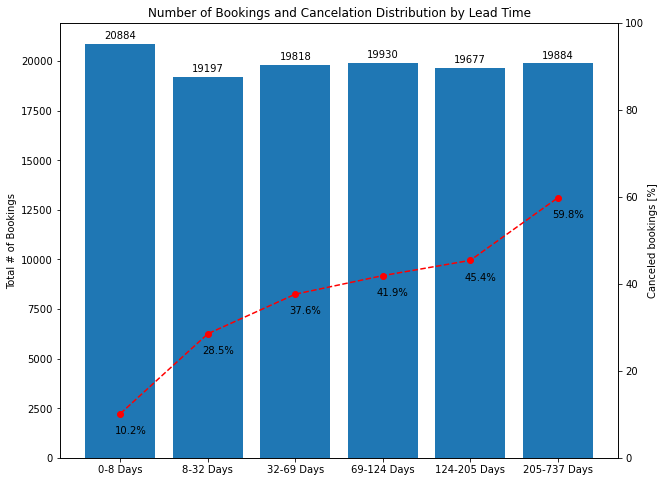

In [68]:
df_leadT = df.loc[:,['lead_time', 'is_canceled']]

df_leadT.loc[:,['LeadT_Buckets']] = pd.qcut(df_leadT['lead_time'], q=6, labels=['0-8 Days', '8-32 Days', '32-69 Days', '69-124 Days', '124-205 Days', '205-737 Days'])
plot_lead_time = df.groupby([df_leadT['LeadT_Buckets'], 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='LeadT_Buckets', values=0)
plot_lead_time.loc[:,['sum_bookings']] = plot_lead_time[0] + plot_lead_time[1]

plot_lead_time_pct = round(plot_lead_time.div(plot_lead_time['sum_bookings'], axis=0)*100, 2)
plot_lead_time_pct = plot_lead_time_pct.drop('sum_bookings', axis=1)
plot_lead_time_pct_canceled = plot_lead_time_pct[1]

x_axis = plot_lead_time.index

fig, ax1 = plt.subplots(figsize = (10,8))
ax1.bar(x_axis, plot_lead_time['sum_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by Lead Time')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, plot_lead_time['sum_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,plot_lead_time_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Lead Time')
ax2.set_ylim((0, 100))
for x,y in zip(x_axis, plot_lead_time_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')

**Lead time is a good predictor since there is a strong positive trend between cancelation perentage and it**

### Days in waiting list

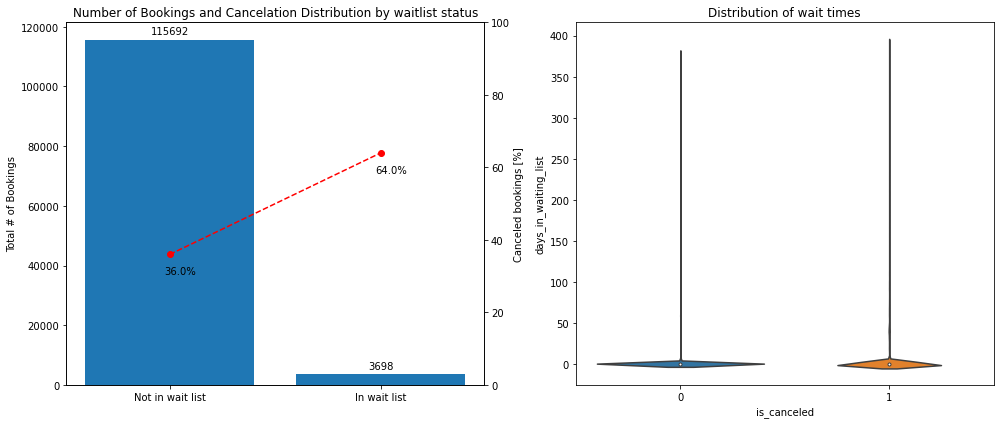

In [69]:
#Create Series
plot_waitlist = df.groupby(['days_in_waiting_list', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='days_in_waiting_list', values=0)
plot_waitlist = plot_waitlist.fillna(0)

# Create Dictionary & Data Frame
plot_waitlist_dict = {'not_canceled':plot_waitlist[0], 'canceled':plot_waitlist[1]}
df_plot_waitlist = pd.DataFrame(plot_waitlist_dict).reset_index()

#Create new column 'total bookings' containing the sum of canceled & not canceled bookings
df_plot_waitlist['total_bookings'] = df_plot_waitlist['not_canceled'] + df_plot_waitlist['canceled']

#Sort the df_plot_country by total_bookings descending
df_plot_waitlist_sorted = df_plot_waitlist.sort_values(by=['total_bookings'], ascending=False)


#Take out top 
df_plot_waitlist_top = df_plot_waitlist.sort_values(['total_bookings'], ascending=False, ignore_index=True)[:1]
df_plot_waitlist_top.set_index('days_in_waiting_list', inplace=True)

#Add a row with all the rest 
df_plot_waitlist_top.loc['IN wait list',:] = df_plot_waitlist_sorted.iloc[1:, 1:4].sum(axis=0)
df_plot_waitlist_top_pct = round(df_plot_waitlist_top.div(df_plot_waitlist_top['total_bookings'], axis=0), 2)*100
df_plot_waitlist_top_pct_canceled = df_plot_waitlist_top_pct['canceled']


#Axis X
x_axis = ['Not in wait list', 'In wait list']

fig, (ax1,ax3) = plt.subplots(1,2, figsize = (14,6))

ax1.bar(x_axis, df_plot_waitlist_top['total_bookings'])
ax1.set_title ('Number of Bookings and Cancelation Distribution by waitlist status')
ax1.set_ylabel('Total # of Bookings')
for x,y in zip(x_axis, df_plot_waitlist_top['total_bookings']):
    label = "{:.0f}".format(y)
    ax1.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center')    

ax2 = ax1.twinx()

ax2.plot(x_axis,df_plot_waitlist_top_pct_canceled, 'ro--')
ax2.set_ylabel('Canceled bookings [%]')
ax2.set_xlabel('Booking Changes')
ax2.set_ylim((0, 100))
for x,y in zip(x_axis, df_plot_waitlist_top_pct_canceled):
    label = "{:.1f}%".format(y)
    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,-20), # distance from text to points (x,y)
                 ha='center')
sns.violinplot(y='days_in_waiting_list', x='is_canceled', data=df, ax=ax3)
ax3.set_title('Distribution of wait times')
fig.tight_layout()

**Major part (almost 97%) of all reservations are made without being put in watings list thus leads to highly skewed distribution of values**

# 2. Information Value 

### **Preparing the Categorical variables for Information Value calculation**

In [70]:
df_categorical = df.copy()
df_categorical = df_categorical.drop(['lead_time', 'hotel','agent','company','reservation_status', 'reservation_status_date', 
                                      'Year_Month'], axis=1)
df_categorical = df_categorical.dropna()


,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,2015,July,27,1,0,0,2,0.0,0,...,0,C,C,3,No Deposit,0,Transient,0.00,0,0
1,0,2015,July,27,1,0,0,2,0.0,0,...,0,C,C,4,No Deposit,0,Transient,0.00,0,0
2,0,2015,July,27,1,0,1,1,0.0,0,...,0,A,C,0,No Deposit,0,Transient,75.00,0,0
3,0,2015,July,27,1,0,1,1,0.0,0,...,0,A,A,0,No Deposit,0,Transient,75.00,0,0
4,0,2015,July,27,1,0,2,2,0.0,0,...,0,A,A,0,No Deposit,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,2017,August,35,30,2,5,2,0.0,0,...,0,A,A,0,No Deposit,0,Transient,96.14,0,0
119386,0,2017,August,35,31,2,5,3,0.0,0,...,0,E,E,0,No Deposit,0,Transient,225.43,0,2
119387,0,2017,August,35,31,2,5,2,0.0,0,...,0,D,D,0,No Deposit,0,Transient,157.71,0,4
119388,0,2017,August,35,31,2,5,2,0.0,0,...,0,A,A,0,No Deposit,0,Transient,104.40,0,0


### **Define function for Information Value Calculation**

In [32]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10): #boolean, unsigned integer, floating-point
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop') #- Divide dataset in to 10 bins
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [71]:
iv, woe = iv_woe(data = df_categorical, target = 'is_canceled', bins=5, show_woe = False)
iv = iv.sort_values(by=['IV'], ascending=False)
iv.info()
iv

Information value of arrival_date_year is 0.002763
Information value of arrival_date_month is 0.020556
Information value of arrival_date_week_number is 0.015921
Information value of arrival_date_day_of_month is 0.001059
Information value of stays_in_weekend_nights is 0.000184
Information value of stays_in_week_nights is 0.049059
Information value of adults is 0.000578
Information value of children is 0.003545
Information value of babies is 0.006041
Information value of meal is 0.010975
Information value of country is 0.589759
Information value of market_segment is 0.325358
Information value of distribution_channel is 0.152706
Information value of is_repeated_guest is 0.039709
Information value of previous_cancellations is 0.0
Information value of previous_bookings_not_canceled is 0.0
Information value of reserved_room_type is 0.02361
Information value of assigned_room_type is 0.197395
Information value of booking_changes is 0.0
Information value of deposit_type is 1.95074
Information v

,Variable,IV
0,deposit_type,1.950740
0,required_car_parking_spaces,0.893266
0,country,0.589759
0,total_of_special_requests,0.326412
0,market_segment,0.325358
0,assigned_room_type,0.197395
0,distribution_channel,0.152706
0,customer_type,0.088935
0,stays_in_week_nights,0.049059
0,is_repeated_guest,0.039709


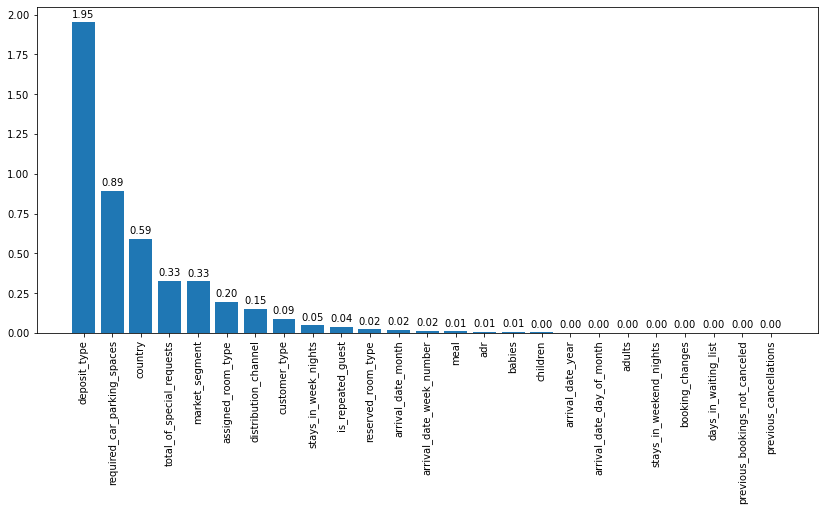

In [34]:
x_axis = iv['Variable']
y_axis = iv['IV'] 

fig, ax = plt.subplots(figsize= (14,6))
ax.bar(x_axis, y_axis)
ax.tick_params(axis='x', rotation=90)
for x,y in zip(x_axis, y_axis):
    label = "{:.2f}".format(y)
    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') 

**Results**

Having in mind the advisable ranges for Informaton Value magnitutes (>0.02 but not <0.5) leads us to the stated parameters as possible predictors :
1. total_of_special_requests
2. market_segment
3. assigned_room_type
4. distribution_channel
5. customer_type
6. stays_in_week_nights
7. is_repeated_guest



# 3. T-test for numerical variables

In [73]:
df_leadtime = df.groupby(['lead_time', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='lead_time', values=0)
stats.ttest_ind(df_leadtime[0], df_leadtime[1], nan_policy='omit')

Ttest_indResult(statistic=4.543579931090847, pvalue=6.297721009751704e-06)

**With p-value result well below the 0.05 threshhold we could say that Lead Time is a significant predictor**

In [77]:
df_numerical_d_in_waitlist = df.groupby(['days_in_waiting_list', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='days_in_waiting_list', values=0)
stats.ttest_ind(df_numerical_d_in_waitlist[0], df_numerical_d_in_waitlist[1], nan_policy='omit')

Ttest_indResult(statistic=0.41347746725584705, pvalue=0.6796976287817178)

**P-value for days in waitlist is significantly higher that the 0.05, thus the variable should not be used as a reliable predictor**

In [78]:
df_adults = df.groupby(['adults', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='adults', values=0)

stats.ttest_ind(df_adults[0], df_adults[1], nan_policy='omit')

Ttest_indResult(statistic=1.6437864028725573, pvalue=0.11858503367233035)

**P-value for adults proves to be higher that the 0.05, thus the variable should not be used as a reliable predictor**

In [79]:
df_babies = df.groupby(['babies', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='babies', values=0)

stats.ttest_ind(df_babies[0], df_babies[1], nan_policy='omit')

Ttest_indResult(statistic=0.012969450530753606, pvalue=0.9900726571764896)

**P-value for number of babies proves to be higher that the 0.05, thus the variable should not be used as a reliable predictor**

In [80]:
df_spec_requests= df.groupby(['total_of_special_requests', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='total_of_special_requests', values=0)
stats.ttest_ind(df_spec_requests[0], df_spec_requests[1], nan_policy='omit')

Ttest_indResult(statistic=0.623942604330591, pvalue=0.5466341314340291)

**P-value for number of special requests proves to be higher that the 0.05, thus the variable should not be used as a reliable predictor**

In [ ]:
df_prev_cancel= df.groupby(['previous_cancellations', 'is_canceled']).size().reset_index().pivot(columns='is_canceled', index='previous_cancellations', values=0)

stats.ttest_ind(df_prev_cancel[0], df_prev_cancel[1], nan_policy='omit')

**P-value for number previous cancelations to be higher that the 0.05, thus the variable should not be used as a reliable predictor**

## **Heatmap for numerical variables**

Text(0.5, 1.0, 'Numerical Variables Heatmap')

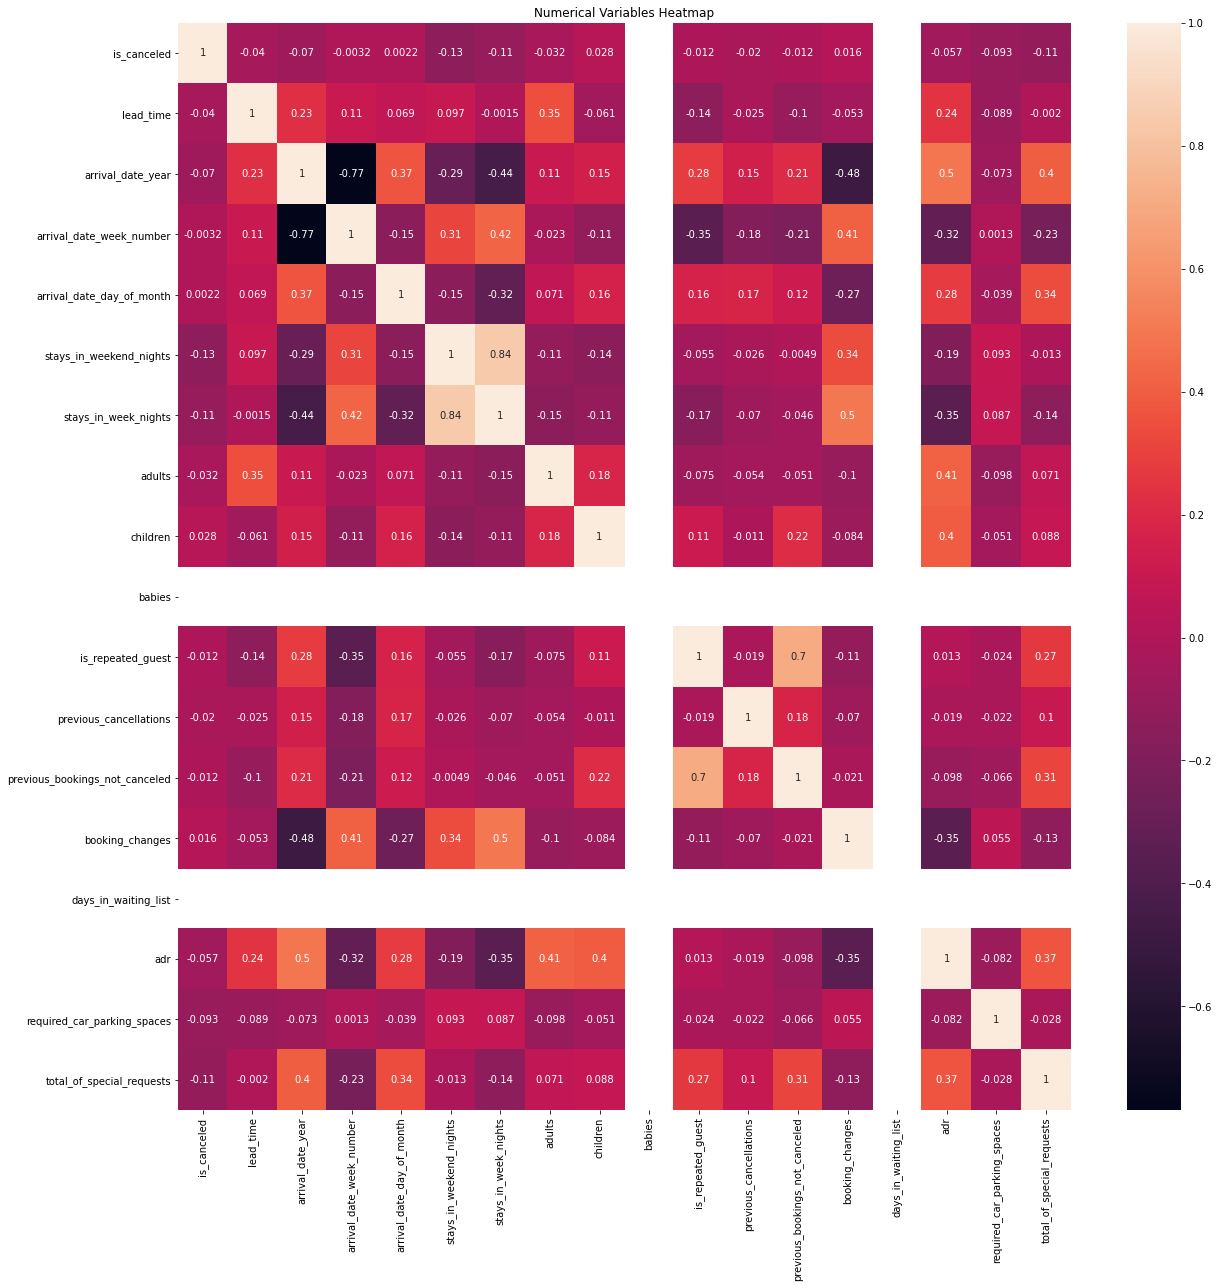

In [112]:
df_numerical = df[df.select_dtypes(include=np.number).columns.tolist()]
df_numerical = df_numerical.dropna()

df_numerical = df_numerical.drop(['agent', 'company'], axis=1)
df_numerical.isnull().sum()


fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_numerical.corr(), annot=True, ax=ax)
plt.title('Numerical Variables Heatmap')

## Results
 **Only lead_time is a reliable numerical variable**

# 4. Logistic Regression

## Prepare the data set

In [37]:
#We will use only seven categorical (derived from WOE and IV method) and one numerical variables (checked with T-test)
df_final = df[['is_canceled','country','total_of_special_requests', 'market_segment', 'assigned_room_type', 
                     'distribution_channel', 'customer_type', 'stays_in_week_nights','is_repeated_guest', 'lead_time']]
df_final = df_final.fillna(0)
df_final = pd.concat([df_final, pd.get_dummies(df_final['market_segment'])],axis=1)
df_final = pd.concat([df_final, pd.get_dummies(df_final['assigned_room_type'])],axis=1)
df_final = pd.concat([df_final, pd.get_dummies(df_final['distribution_channel'])],axis=1)
df_final = pd.concat([df_final, pd.get_dummies(df_final['customer_type'])],axis=1)
df_final = pd.concat([df_final, pd.get_dummies(df_final['country'])],axis=1)

df_final_clean = df_final.drop(['country','market_segment','assigned_room_type', 'distribution_channel', 'customer_type'], axis=1)


In [38]:
X = df_final_clean.loc[:, df_final_clean.columns != 'is_canceled']
y = df_final_clean.loc[:, df_final_clean.columns == 'is_canceled']

In [39]:
#Import need scikit packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [40]:
# Split the file into training and test parts (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Standardize variables**

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [123]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train.values.ravel())

LogisticRegression()

In [120]:
y_pred = logreg.predict(X_test)

In [121]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [129]:
LogReg_matr = confusion_matrix(y_test, y_pred)

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     22371
           1       0.77      0.62      0.69     13446

    accuracy                           0.79     35817
   macro avg       0.78      0.75      0.76     35817
weighted avg       0.79      0.79      0.78     35817



## 5. **Decision Tree**

In [51]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

In [52]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [153]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
DecTr = confusion_matrix(y_test, y_pred)
DecTr

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     22371
           1       0.73      0.69      0.71     13446

    accuracy                           0.79     35817
   macro avg       0.78      0.77      0.77     35817
weighted avg       0.79      0.79      0.79     35817



array([[18980,  3391],
       [ 4107,  9339]], dtype=int64)

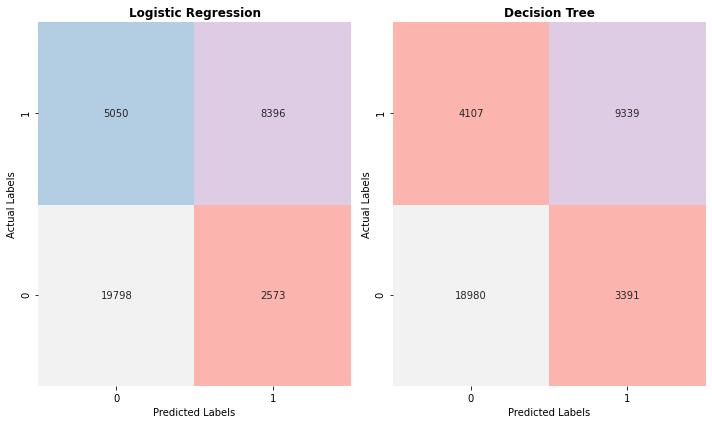

In [152]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
sns.heatmap(DecTr,annot=True, fmt="d", cbar=False, cmap='Pastel1',ax=ax2).set_ylim([0,2])
ax2.set_title("Decision Tree", weight='bold')
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('Actual Labels')

sns.heatmap(LogReg_matr,annot=True, fmt="d", cbar=False, cmap='Pastel1', ax=ax1).set_ylim([0,2])
ax1.set_title("Logistic Regression", weight='bold')
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('Actual Labels')
fig.tight_layout()